In [3]:
import pandas as pd
import pyspark
import pyspark.sql.functions as F
# import matplotlib.pyplot as plt

import os
import re

dpath = os.path.expanduser('~/Dropbox/Projects/data/')

In [4]:
# %matplotlib inline

In [5]:
# %install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime

In [6]:
icd9 = pd.read_excel(dpath + 'icd9/CMS32_DESC_LONG_SHORT_DX.xlsx')
icd9.columns = ['icd9', 'long', 'short']

icd9.head()

,icd9,long,short
0,0010,Cholera due to vibrio cholerae,Cholera d/t vib cholerae
1,0011,Cholera due to vibrio cholerae el tor,Cholera d/t vib el tor
2,0019,"Cholera, unspecified",Cholera NOS
3,0020,Typhoid fever,Typhoid fever
4,0021,Paratyphoid fever A,Paratyphoid fever a


time: 1.06 s


In [7]:
icd = spark.createDataFrame(icd9[['long']])
icd = icd[~icd.long.rlike('unspec')]
print icd.count()
# icd = icd.withColumn('long', F.regexp_replace(F.lower(icd.long), '[,()]', ''))
icd = icd.withColumn('long', F.regexp_replace(F.lower(icd.long), '[^\sa-z]', ''))
print icd.count()
icd = icd.withColumn('long', F.regexp_replace(F.lower(icd.long), '\s+?', ' '))

icd.show(truncate=False)

12060
12060
+-------------------------------------+
|long                                 |
+-------------------------------------+
|cholera due to vibrio cholerae       |
|cholera due to vibrio cholerae el tor|
|typhoid fever                        |
|paratyphoid fever a                  |
|paratyphoid fever b                  |
|paratyphoid fever c                  |
|salmonella gastroenteritis           |
|salmonella septicemia                |
|salmonella meningitis                |
|salmonella pneumonia                 |
|salmonella arthritis                 |
|salmonella osteomyelitis             |
|other localized salmonella infections|
|other specified salmonella infections|
|shigella dysenteriae                 |
|shigella flexneri                    |
|shigella boydii                      |
|shigella sonnei                      |
|other specified shigella infections  |
|staphylococcal food poisoning        |
+-------------------------------------+
only showing top 20 rows

ti

In [8]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol="long", outputCol="words")
wordsData = tokenizer.transform(icd)
wordsData.select('words').show(truncate=False)

+---------------------------------------------+
|words                                        |
+---------------------------------------------+
|[cholera, due, to, vibrio, cholerae]         |
|[cholera, due, to, vibrio, cholerae, el, tor]|
|[typhoid, fever]                             |
|[paratyphoid, fever, a]                      |
|[paratyphoid, fever, b]                      |
|[paratyphoid, fever, c]                      |
|[salmonella, gastroenteritis]                |
|[salmonella, septicemia]                     |
|[salmonella, meningitis]                     |
|[salmonella, pneumonia]                      |
|[salmonella, arthritis]                      |
|[salmonella, osteomyelitis]                  |
|[other, localized, salmonella, infections]   |
|[other, specified, salmonella, infections]   |
|[shigella, dysenteriae]                      |
|[shigella, flexneri]                         |
|[shigella, boydii]                           |
|[shigella, sonnei]                     

In [9]:
from pyspark.ml.feature import StopWordsRemover

remover = StopWordsRemover(inputCol="words", outputCol="filtered")
filteredData = remover.transform(wordsData)
filteredData.select('filtered').show(truncate=False)

+-----------------------------------------+
|filtered                                 |
+-----------------------------------------+
|[cholera, due, vibrio, cholerae]         |
|[cholera, due, vibrio, cholerae, el, tor]|
|[typhoid, fever]                         |
|[paratyphoid, fever]                     |
|[paratyphoid, fever, b]                  |
|[paratyphoid, fever, c]                  |
|[salmonella, gastroenteritis]            |
|[salmonella, septicemia]                 |
|[salmonella, meningitis]                 |
|[salmonella, pneumonia]                  |
|[salmonella, arthritis]                  |
|[salmonella, osteomyelitis]              |
|[localized, salmonella, infections]      |
|[specified, salmonella, infections]      |
|[shigella, dysenteriae]                  |
|[shigella, flexneri]                     |
|[shigella, boydii]                       |
|[shigella, sonnei]                       |
|[specified, shigella, infections]        |
|[staphylococcal, food, poisonin

In [10]:
import itertools
rows_list = []
# for r in filteredData.limit(5).select('filtered').rdd.map(lambda r: list(r)[0]).collect():
for r in filteredData.select('filtered').rdd.map(lambda r: list(r)[0]).collect():
    r = [i.encode('utf-8') for i in r]
# permutations are for directional
    for pair in itertools.combinations(r, r=2):
#         print pair
        if pair[0] != '' and pair[1] != '':
            if pair[0] > pair[1]:
                a, b = pair[1], pair[0]
            else:
                a, b = pair[0], pair[1]
        dict1 = {'n1': a, 'n2': b}
        rows_list.append(dict1)

df = pd.DataFrame(rows_list)
df.head()

,n1,n2
0,cholera,due
1,cholera,vibrio
2,cholera,cholerae
3,due,vibrio
4,cholerae,due


time: 903 ms


In [11]:
df[df.n1 == '']

,n1,n2


time: 12.8 ms


In [12]:
dfc = df.groupby(['n1', 'n2']).size().reset_index()
dfc.columns = ['n1', 'n2', 'c']
dfc = dfc[dfc.c > 30]
print dfc.count()
dfc.head()

n1    751
n2    751
c     751
dtype: int64


,n1,n2,c
246,abnormal,nonspecific,40
417,abortion,complete,36
418,abortion,complicated,63
438,abortion,incomplete,36
439,abortion,induced,36


time: 62.2 ms


In [ ]:
import networkx as nx
G=nx.Graph()
# G.clear()

for r in dfc[dfc.c > 3].iterrows():
#     print r[1][0], r[1][1], r[1][2]
    G.add_edge(r[1][0], r[1][1], weight = r[1][2])

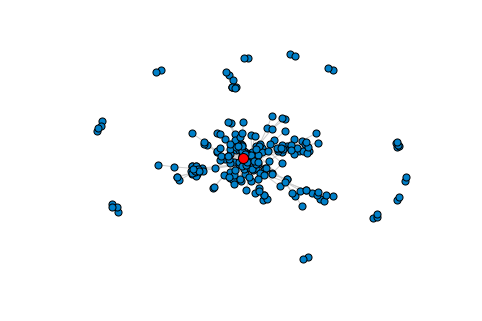

time: 296 ms


In [108]:
from operator import itemgetter

# Accessing the highest degree node
center, degree = sorted(G.degree().items(), key=itemgetter(1), reverse=True)[0]

# A special type of subgraph
ego = nx.ego_graph(G, center)

# pos = nx.spring_layout(G)
pos=nx.fruchterman_reingold_layout(G)


nx.draw(G, pos, node_color='#0080C9', edge_color='#cccccc', node_size=50)
nx.draw_networkx_nodes(G, pos, nodelist=[center], node_size=100, node_color="r")
plt.show()

# Fruchterman Reingold layout with networkx and Plotly

In [109]:
import plotly.plotly as py
from plotly.graph_objs import *

time: 1.38 s


In [110]:
py.sign_in('victoongo', '7ucdyecjqd')

time: 845 µs


In [111]:
labels=list(G.nodes())
N = len(labels)
V = range(N)
E=[e for e in G.edges()]# list of edges

time: 2.94 ms


In [112]:
N

235

time: 2.23 ms


In [113]:
pos=nx.fruchterman_reingold_layout(G)

Xv=[pos[k][0] for k in labels]
Yv=[pos[k][1] for k in labels]
Xed=[]
Yed=[]
for edge in E:
    Xed+=[pos[edge[0]][0],pos[edge[1]][0], None]
    Yed+=[pos[edge[0]][1],pos[edge[1]][1], None] 
    
trace3=Scatter(x=Xed,
               y=Yed,
               mode='lines',
               line=Line(color='rgb(210,210,210)', width=1),
               hoverinfo='none'
               )
trace4=Scatter(x=Xv,
               y=Yv,
               mode='markers',
               name='net',
               marker=Marker(symbol='dot',
                             size=5, 
                             color='#6959CD',
                             line=Line(color='rgb(50,50,50)', width=0.5)
                             ),
               text=labels,
               hoverinfo='text'
               )


annot="This networkx.Graph has the Fruchterman-Reingold layout<br>Code:"+\
"<a href='http://nbviewer.ipython.org/gist/empet/07ea33b2e4e0b84193bd'> [2]</a>"


axis=dict(showline=False, # hide axis line, grid, ticklabels and  title
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title='' 
          )

width=800
height=800
layout=Layout(title= "Network of ICD9 long words"+\
              "<br> Data source: <a href='https://networkdata.ics.uci.edu/data.php?id=11'> [1]</a>",  
    font= Font(size=12),
    showlegend=False,
    autosize=False,
    width=width,
    height=height,
    xaxis=XAxis(axis),
    yaxis=YAxis(axis),          
    margin=Margin(
        l=40,
        r=40,
        b=85,
        t=100,
    ),
    hovermode='closest',
    annotations=Annotations([
           Annotation(
           showarrow=False, 
            text='This nx.Graph has the Fruchterman Reingold layout',  
            xref='paper',     
            yref='paper',     
            x=0,  
            y=-0.1,  
            xanchor='left',   
            yanchor='bottom',  
            font=Font(
            size=14 
            )     
            )
        ]),           
    )


data1=Data([trace3, trace4])
fig1=Figure(data=data1, layout=layout)
fig1['layout']['annotations'][0]['text']=annot
py.iplot(fig1, filename='icd9-words-network')


time: 2.06 s


# force_directed_graph, D3

In [6]:
from IPython.core.display import HTML
import d3_lib

import pandas as pd
import random
random.seed(42)

In [3]:
HTML(d3_lib.set_styles(['basic_axis','basic_line','basic_scatter','force_directed_graph','day-hr-heatmap']))

In [4]:
HTML('<script src="lib/d3/d3.min.js"></script>')

In [17]:
n_nodes = 50
p_edge = 0.05
graph = {"nodes": [], "links": []}
for i in range(n_nodes):
    graph["nodes"].append( {"name": "i" + str(i), "group": int(random.uniform(1,11))} )
for i in range(n_nodes):
    for j in range(n_nodes):
        if random.uniform(0,1) < p_edge:
            graph["links"].append( {"source": i, "target": j, "value": random.uniform(0.5,3)} )

In [114]:
graph = {"nodes": [], "links": []}

for r in dfc[dfc.c > 3].iterrows():
    graph["links"].append( {"source": r[1][0], "target": r[1][1], "value": r[1][2]} )

time: 94.3 ms


In [122]:
for n in G.nodes():
#     print n
    graph["nodes"].append( {"name": n, "group": int(random.uniform(1,11))} )
#     G.add_edge(r[1][0], r[1][1], weight = r[1][2])

time: 2.18 ms


In [123]:
graph['nodes']

[{'group': 8, 'name': 'operations'},
 {'group': 8, 'name': 'otherwise'},
 {'group': 1, 'name': 'fetus'},
 {'group': 7, 'name': 'thigh'},
 {'group': 9, 'name': 'consciousness'},
 {'group': 6, 'name': 'less'},
 {'group': 1, 'name': 'caused'},
 {'group': 5, 'name': 'tubercle'},
 {'group': 7, 'name': 'blisters'},
 {'group': 7, 'name': 'sites'},
 {'group': 6, 'name': 'obstruction'},
 {'group': 1, 'name': 'underlying'},
 {'group': 7, 'name': 'motorcycle'},
 {'group': 2, 'name': 'malignant'},
 {'group': 3, 'name': 'skin'},
 {'group': 6, 'name': 'partial'},
 {'group': 8, 'name': 'subarachnoid'},
 {'group': 1, 'name': 'suicide'},
 {'group': 9, 'name': 'erythema'},
 {'group': 2, 'name': 'benign'},
 {'group': 7, 'name': 'personal'},
 {'group': 7, 'name': 'nervous'},
 {'group': 8, 'name': 'labor'},
 {'group': 4, 'name': 'better'},
 {'group': 5, 'name': 'neoplasm'},
 {'group': 9, 'name': 'present'},
 {'group': 3, 'name': 'nodes'},
 {'group': 8, 'name': 'histological'},
 {'group': 8, 'name': 'postpa

time: 39.9 ms


In [18]:
graph

{'links': [{'source': 0, 'target': 2, 'value': 0.5551428097420714},
  {'source': 1, 'target': 6, 'value': 2.0938250639108222},
  {'source': 1, 'target': 10, 'value': 2.4812071876727417},
  {'source': 2, 'target': 17, 'value': 0.531248214206526},
  {'source': 3, 'target': 44, 'value': 2.5074548035335464},
  {'source': 4, 'target': 37, 'value': 2.0576596561949185},
  {'source': 6, 'target': 5, 'value': 1.6378038207377352},
  {'source': 7, 'target': 11, 'value': 1.1686919121570414},
  {'source': 7, 'target': 43, 'value': 1.2871094881313112},
  {'source': 7, 'target': 49, 'value': 1.8163894473558888},
  {'source': 8, 'target': 43, 'value': 2.0834398678838797},
  {'source': 9, 'target': 5, 'value': 2.0680732767551215},
  {'source': 9, 'target': 10, 'value': 0.6266292360781172},
  {'source': 9, 'target': 37, 'value': 2.9084114655606457},
  {'source': 9, 'target': 39, 'value': 1.5616631051285443},
  {'source': 9, 'target': 42, 'value': 2.446443941147529},
  {'source': 10, 'target': 19, 'value

In [124]:
HTML(d3_lib.draw_graph('force_directed_graph',{'data': graph}))

time: 6.23 ms
